# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
# suppress warnings
import warnings
warnings.filterwarnings("ignore")


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomApply([transforms.RandomRotation(5),transforms.CenterCrop(32)], p=0.5)])

# Create training set and define training dataloader
# parameters 
torch.manual_seed(28) 
val_size = 5000
batch_size = 128

# def loaders 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = len(trainset) - val_size
train_ds, val_ds = torch.utils.data.random_split(trainset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

# a better function to show the data in grid format
def myshow5(img,labels):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    left = 0
    bottom = -0.1
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    label_data = []
    for i in range(len(labels)):
        label_data.append(classes[labels[i]])

    plt.xticks([17, 52, 86, 120, 154],label_data)  # Set label locations.
    plt.yticks([])
    plt.show()

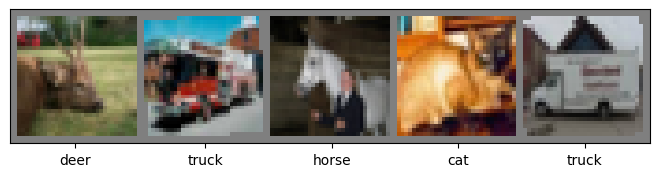

In [4]:
# Explore data
# show5(trainloader)
dataiter = iter(train_loader)
batch = next(dataiter)
labels = batch[1][0:5]
images = batch[0][0:5]
myshow5(torchvision.utils.make_grid(images),labels)
# print labels
# print(" ".join(f"{classes[labels[j]]}" for j in range(len(labels))))
# myshow5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
## YOUR CODE HERE ##
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        return self.network(x)



net = Net()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
## YOUR CODE HERE ##
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = net.to(device)

In [7]:
# Nice summary of model based on feedback (updated to new package name)
from torchinfo import summary
summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Conv2d: 2-1                       [128, 32, 32, 32]         896
│    └─ReLU: 2-2                         [128, 32, 32, 32]         --
│    └─Conv2d: 2-3                       [128, 32, 32, 32]         9,248
│    └─ReLU: 2-4                         [128, 32, 32, 32]         --
│    └─MaxPool2d: 2-5                    [128, 32, 16, 16]         --
│    └─Conv2d: 2-6                       [128, 64, 16, 16]         18,496
│    └─ReLU: 2-7                         [128, 64, 16, 16]         --
│    └─Conv2d: 2-8                       [128, 64, 16, 16]         36,928
│    └─ReLU: 2-9                         [128, 64, 16, 16]         --
│    └─MaxPool2d: 2-10                   [128, 64, 8, 8]           --
│    └─Conv2d: 2-11                      [128, 128, 8, 8]          73,856

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
## YOUR CODE HERE ##
loss_values = []
val_loss_values = []
accuracy_values = []
best_accuracy = 0.0 
num_epochs = 10
for epoch in range(1, num_epochs+1):  # loop over the dataset multiple times
        running_loss = 0.0
        running_vall_loss = 0.0
        running_accuracy = 0.0 
        for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                # if i % 2000 == 1999:    # print every 2000 mini-batches
                #         print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                #         running_loss = 0.0
        loss_values.append(running_loss/len(train_loader))
        with torch.no_grad():
            model.eval()
            total = 0
            for data in val_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                val_loss = criterion(outputs, labels) 
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                running_accuracy += (predicted == labels).sum().item()
                running_vall_loss += val_loss.item()
            # print(f'Accuracy of the network on the 5000 validation images: {100 * running_accuracy / total}%')
            # print(f'Validation loss: {running_vall_loss/len(val_loader)}')
            val_loss_values.append(running_vall_loss/len(val_loader))
        accuracy_values.append(100 * running_accuracy / total)

        if 100 * running_accuracy / total > best_accuracy:
            best_accuracy = 100 * running_accuracy / total
            torch.save(model.state_dict(), 'best_model.pt')
            print(f'Best model saved at epoch {epoch+1} with accuracy {best_accuracy}%')
# print('Finished Training')



Best model saved at epoch 2 with accuracy 46.74%
Best model saved at epoch 3 with accuracy 56.58%
Best model saved at epoch 4 with accuracy 66.22%
Best model saved at epoch 5 with accuracy 69.48%
Best model saved at epoch 6 with accuracy 71.92%
Best model saved at epoch 7 with accuracy 73.52%
Best model saved at epoch 8 with accuracy 74.66%
Best model saved at epoch 9 with accuracy 74.74%
Best model saved at epoch 10 with accuracy 76.24%


Plot the training loss (and validation loss/accuracy, if recorded).

In [9]:
# plot the training loss and validation loss in plotly plot
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1,num_epochs+1), y=loss_values,
                    mode='lines+markers',
                    name='Training Loss'))
fig.add_trace(go.Scatter(x=np.arange(1,num_epochs+1), y=val_loss_values,
                    mode='lines+markers',
                    name='Validation Loss'))
fig.update_layout(title='Training and Validation Loss',
                     xaxis_title='Epoch',
                        yaxis_title='Loss') 
fig.show()


In [10]:
# plot the validation accuracy in plotly plot
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1,num_epochs+1), y=accuracy_values,
                    mode='lines+markers',
                    name='Validation Accuracy'))
fig.update_layout(title='Validation Accuracy',
                        xaxis_title='Epoch',
                        yaxis_title='Accuracy')
fig.show()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
## YOUR CODE HERE ##
# Original source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# load the best model
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
running_accuracy = 0 
total = 0 
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_accuracy += (predicted == labels).sum().item()
print(f'Accuracy of the network on the test set of', len(testset),'is', 100 * running_accuracy / total , '%')

Accuracy of the network on the test set of 10000 is 75.94 %


In [12]:
# Original Source https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 85.9 %
Accuracy for class: car   is 89.1 %
Accuracy for class: bird  is 68.9 %
Accuracy for class: cat   is 56.8 %
Accuracy for class: deer  is 72.6 %
Accuracy for class: dog   is 64.0 %
Accuracy for class: frog  is 82.7 %
Accuracy for class: horse is 79.2 %
Accuracy for class: ship  is 82.8 %
Accuracy for class: truck is 80.6 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [13]:
# Mode is already saved for best accuracy in training loop in previous cell
# if 100 * running_accuracy / total > best_accuracy:
#             best_accuracy = 100 * running_accuracy / total
#             torch.save(model.state_dict(), 'best_model.pt')
#             print(f'Best model saved at epoch {epoch+1} with accuracy {best_accuracy}%')


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Based on the results, my model returns test accuracy of 75.9%. This is better than the 70% target accuracy. I would recommend building a more complex model and implementing more advanced augmentation techniques to further improve the accuracy.
